In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('/content/sample_data/sample_dataset.csv',index_col='Date',parse_dates=True)
df.index.freq='D'

In [18]:
df.head()

,Sales
Date,
2020-02-01,3461
2020-02-02,3946
2020-02-03,7225
2020-02-04,9302
2020-02-05,5518


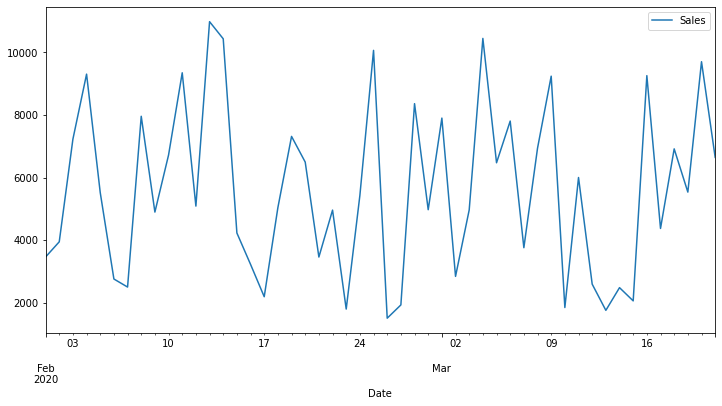

In [20]:
df.head(50).plot(figsize=(12,6))

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

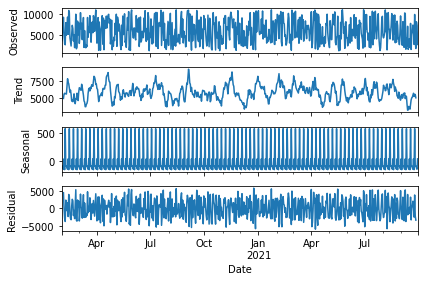

In [22]:
results = seasonal_decompose(df['Sales'])
results.plot();

In [23]:
 len(df)

607

In [25]:

train = df.iloc[:450]
test = df.iloc[450:]

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [27]:
df.head(),df.tail()

(            Sales
 Date             
 2020-02-01   3461
 2020-02-02   3946
 2020-02-03   7225
 2020-02-04   9302
 2020-02-05   5518,             Sales
 Date             
 2021-09-25   3229
 2021-09-26   1584
 2021-09-27   8178
 2021-09-28   7180
 2021-09-29   2582)

In [28]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [29]:
scaled_train[:10]

array([[0.24054643],
       [0.28855672],
       [0.61314591],
       [0.81874876],
       [0.44416947],
       [0.17095625],
       [0.14551574],
       [0.68550782],
       [0.38259751],
       [0.56305682]])

In [30]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [32]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.24054643 0.28855672 0.61314591]
Predict this y: 
 [[0.81874876]]


In [33]:
X.shape

(1, 3, 1)

In [34]:

n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [36]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Fit the model
model.fit(generator,epochs=50)

Epoch 1/50
438/438 [==============================] - 5s 8ms/step - loss: 0.0987
Epoch 2/50
438/438 [==============================] - 5s 11ms/step - loss: 0.0897
Epoch 3/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0885
Epoch 4/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0888
Epoch 5/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0878
Epoch 6/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0875
Epoch 7/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0874
Epoch 8/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0872
Epoch 9/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0884
Epoch 10/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0866
Epoch 11/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0864
Epoch 12/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0865
Epoch 13/50
438/438 [==

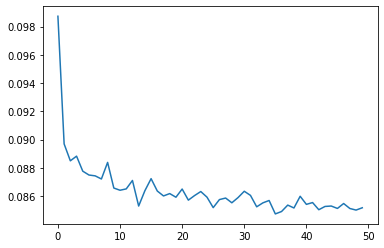

In [39]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [40]:
last_train_batch = scaled_train[-12:]

In [41]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [42]:
model.predict(last_train_batch)

array([[0.47572824]], dtype=float32)

In [43]:
scaled_test[0]

array([0.66580875])

In [44]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [46]:
test.head()

,Sales
Date,
2021-04-26,7757
2021-04-27,7434
2021-04-28,10069
2021-04-29,5517
2021-04-30,3673


In [47]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Sales'],test['Predictions']))
print(rmse)

2919.3139370598806
